## Домашнее задание № 3 (демо). Деревья решений в игрушечной задаче и на данных Adult репозитория UCI

## Часть 1. Игрушечный набор данных "девушка в баре".
Цель – "на пальцах", с помощью игрушечной задачи классификации разобраться в том, как работают деревья решений. Само по себе дерево решений – довольно слабый алгоритм, но основанные на нем алгоритмы случайного леса и градиентного бустинга - пожалуй, лучшее, что есть на сегодняшний день (в задачах, где можно обойтись без нейронных сетей). Поэтому разобраться в том, как работает дерево решений, полезно.

Рассмотрим игрушечную задачу бинарной классификации: поедет ли с Вами девушка из бара? Это будет зависеть от Вашей внешности и красноречия, крепости предлагаемых напитков и, как это ни меркантильно, от количества потраченных в баре денег.

Подключаем необходимые библиотеки.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

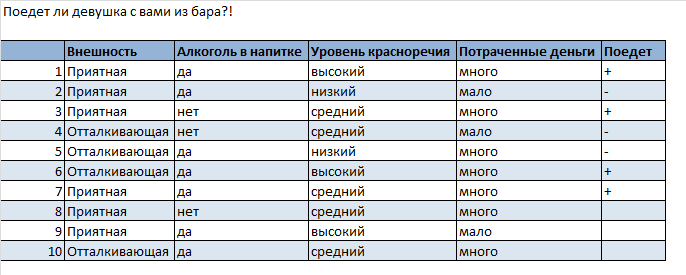

In [2]:
from IPython.display import Image
display(Image(filename=r'C:\GitBash\ods\mlcourse_dataset\toy_data.png'))

#### Создание набора данных

In [3]:
# Создание датафрейма с dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [4]:
features = ['Внешность', 'Алкоголь_в_напитке',
            'Уровень_красноречия', 'Потраченные_деньги']

#### Обучающая выборка

In [5]:
df_train = {}
df_train['Внешность'] = ['приятная', 'приятная', 'приятная', 'отталкивающая',
                         'отталкивающая', 'отталкивающая', 'приятная'] 
df_train['Алкоголь_в_напитке'] = ['да', 'да', 'нет', 'нет', 'да', 'да', 'да']
df_train['Уровень_красноречия'] = ['высокий', 'низкий', 'средний', 'средний', 'низкий',
                                   'высокий', 'средний']
df_train['Потраченные_деньги'] = ['много', 'мало', 'много', 'мало', 'много',
                                  'много', 'много']
df_train['Поедет'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Поедет,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_низкий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,0,1,1,0,1,0,0,0,1
1,1,0,1,1,0,0,1,0,1,0
2,0,0,1,0,1,0,0,1,0,1
3,1,1,0,0,1,0,0,1,1,0
4,1,1,0,1,0,0,1,0,0,1
5,0,1,0,1,0,1,0,0,0,1
6,0,0,1,1,0,0,0,1,0,1


#### Тестовая выборка

In [6]:
df_test = {}
df_test['Внешность'] = ['приятная', 'приятная', 'отталкивающая'] 
df_test['Алкоголь_в_напитке'] = ['нет', 'да', 'да']
df_test['Уровень_красноречия'] = ['средний', 'высокий', 'средний']
df_test['Потраченные_деньги'] = ['много', 'мало', 'много']
df_test = create_df(df_test, features)
df_test

,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,1,0,1,0,1,0,1
1,0,1,1,0,1,0,1,0
2,1,0,1,0,0,1,0,1


In [7]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
y = df_train['Поедет']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Алкоголь_в_напитке_да,Внешность_отталкивающая,Уровень_красноречия_высокий,Уровень_красноречия_средний,Внешность_приятная,Потраченные_деньги_много,Потраченные_деньги_мало,Алкоголь_в_напитке_нет
0,1,0,1,0,1,1,0,0
1,1,0,0,0,1,0,1,0
2,0,0,0,1,1,1,0,1
3,0,1,0,1,0,0,1,1
4,1,1,0,0,0,1,0,0
5,1,1,1,0,0,1,0,0
6,1,0,0,1,1,1,0,0


In [8]:
df_test

,Алкоголь_в_напитке_да,Внешность_отталкивающая,Уровень_красноречия_высокий,Уровень_красноречия_средний,Внешность_приятная,Потраченные_деньги_много,Потраченные_деньги_мало,Алкоголь_в_напитке_нет
0,0,0,0,1,1,1,0,1
1,1,0,1,0,1,0,1,0
2,1,1,0,1,0,1,0,0


#### Построим с помощью sklearn дерево решений, обучив его на обучающей выборке.

In [9]:
clf_rf = RandomForestClassifier(random_state=0)

In [10]:
parameters = {'n_estimators': range(1, 10), 'max_depth': range(1, 5),
              'min_samples_leaf': range(1, 7), 'min_samples_split': range(2, 9)}

In [11]:
grid_search_cv_clf = GridSearchCV(clf_rf, parameters, cv=3)

In [13]:
grid_search_cv_clf.fit(df_train, y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': range(1, 5),
                         'min_samples_leaf': range(1, 7),
                         'min_samples_split': range(2, 9),
                         'n_estimators': range(1, 10)})

In [14]:
grid_search_cv_clf.best_params_

{'max_depth': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 2}

In [15]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

RandomForestClassifier(max_depth=1, n_estimators=2, random_state=0)

In [17]:
feature_importances = best_clf.feature_importances_
feature_importances_df = pd.DataFrame({'features': df_train.columns, 'feature_importances': feature_importances})
feature_importances_df.sort_values('feature_importances', ascending=False)

,features,feature_importances
2,Уровень_красноречия_высокий,0.5
4,Внешность_приятная,0.5
0,Алкоголь_в_напитке_да,0.0
1,Внешность_отталкивающая,0.0
3,Уровень_красноречия_средний,0.0
5,Потраченные_деньги_много,0.0
6,Потраченные_деньги_мало,0.0
7,Алкоголь_в_напитке_нет,0.0


In [18]:
best_clf.score(df_train, y)

0.8571428571428571

In [20]:
y_pred = best_clf.predict(df_test)
y_pred

array([0, 0, 1], dtype=int64)

#### Итог:

In [21]:
df_test['Поедет'] = pd.Series(y_pred)
df_test

C:\Users\Chip\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Алкоголь_в_напитке_да,Внешность_отталкивающая,Уровень_красноречия_высокий,Уровень_красноречия_средний,Внешность_приятная,Потраченные_деньги_много,Потраченные_деньги_мало,Алкоголь_в_напитке_нет,Поедет
0,0,0,0,1,1,1,0,1,0
1,1,0,1,0,1,0,1,0,0
2,1,1,0,1,0,1,0,0,1


### Часть 2. Набор данных "Adult"

Описание набора:

Набор данных UCI Adult : классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более $ 50 000 в год.

Описание признаков:

**Age** – возраст, количественный признак\
**Workclass** – тип работодателя, количественный признак\
**fnlwgt** – итоговый вес обьекта, количественный признак\
**Education** – уровень образования, качественный признак\
**Education_Num** – количество лет обучения, количественный признак\
**Martial_Status** – семейное положение, категориальный признак\
**Occupation** – профессия, категориальный признак\
**Relationship** – тип семейных отношений, категориальный признак\
**Race** – раса, категориальный признак\
**Sex** – пол, качественный признак\
**Capital_Gain** – прирост капитала, количественный признак\
**Capital_Loss** – потери капитала, количественный признак\
**Hours_per_week** – количество часов работы в неделю, количественный признак\
**Country** – страна, категориальный признак\

Целевая переменная: **Target** – уровень заработка, категориальный (бинарный) признак

Считываем обучающую и тестовую выборки.

In [22]:
data_train = pd.read_csv(r'C:\GitBash\ods\mlcourse_dataset\adult_train.csv', sep=',')
data_train

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [23]:
data_test = pd.read_csv(r'C:\GitBash\ods\mlcourse_dataset\adult_test.csv')
data_test

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.


In [24]:
# перекодируем target в числовое поле
data_train.loc[data_train['Target']==' <=50K', 'Target'] = 0
data_train.loc[data_train['Target']==' >50K', 'Target'] = 1

data_test.loc[data_test['Target']==' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target']==' >50K.', 'Target'] = 1

#### Первичный анализ данных.

In [25]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16282,74,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
data_train.Target.value_counts()

0    24720
1     7841
Name: Target, dtype: int64

C:\Users\Chip\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """
C:\Users\Chip\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """
C:\Users\Chip\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """
C:\Users\Chip\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """
C:\Users\Chip\anaconda3\lib\site-packages\ipykernel_launcher.py:

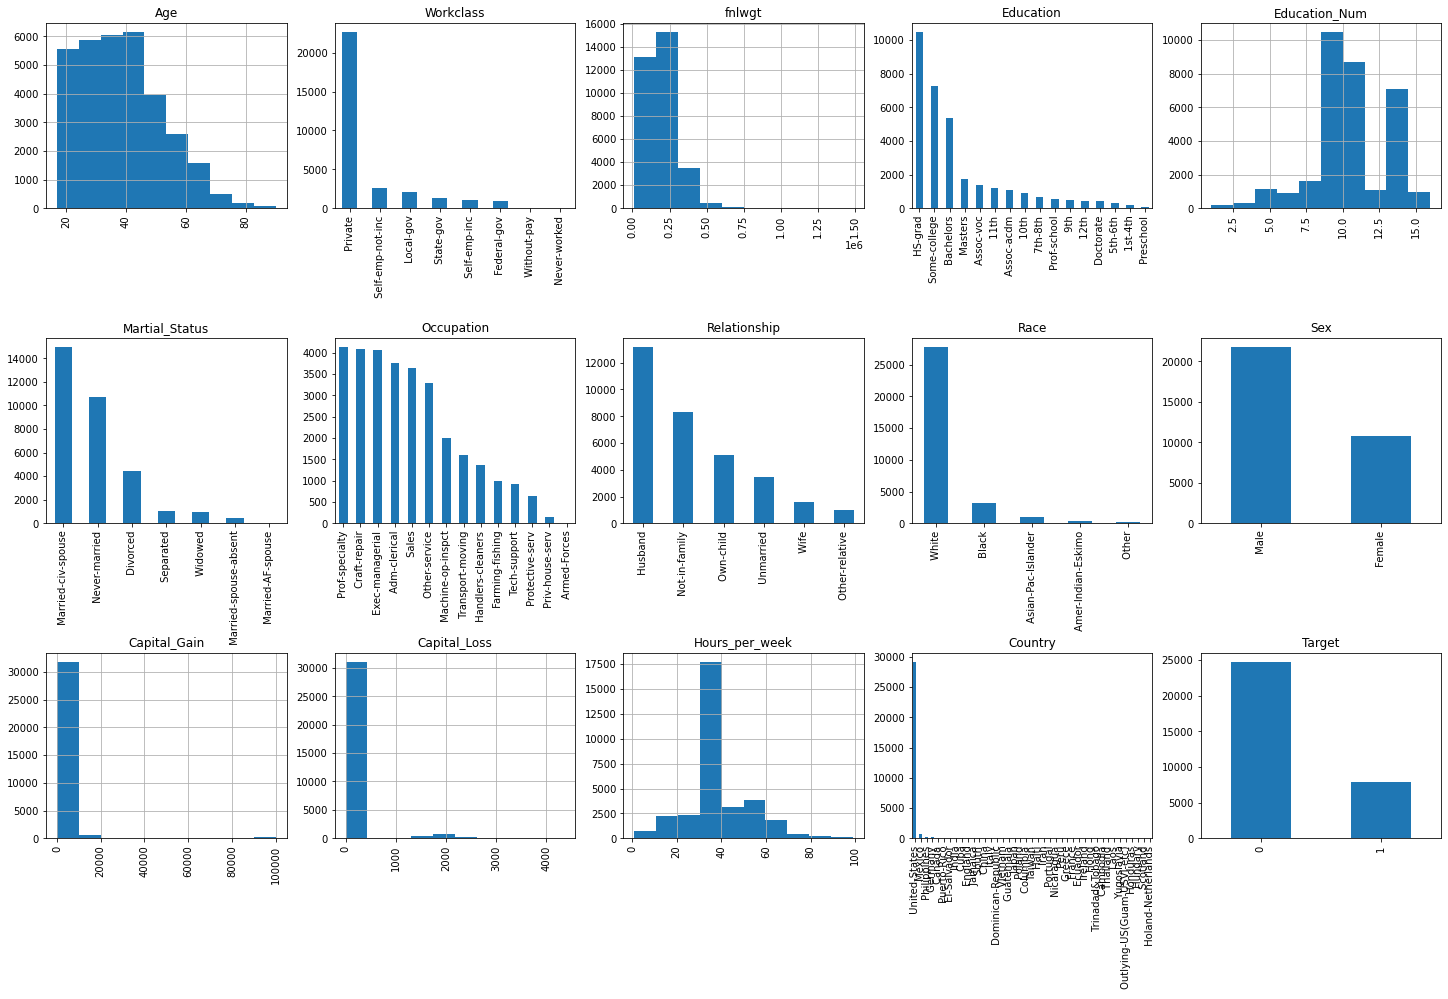

In [27]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

Проверяем типы данных

In [28]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [29]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

Выяснилось, что в тесте возраст отнесен к типу object, необходимо это исправить.

Для начала удалим первую строку датафрейма data_test.

In [30]:
data_test.head(1)

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
data_test = data_test.drop([0,], axis=0)

In [38]:
data_test['Age'] = data_test['Age'].astype('float')

In [39]:
data_test['Age'] = data_test['Age'].astype('Int64')

Также приведем показатели типа float в int для соответствия train и test выборок.

In [40]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

#### Заполним пропуски в количественных полях медианными значениями, а в категориальных – наиболее часто встречающимся значением.

In [45]:
# выделим в выборках категориальные и числовые поля

categorical_columns = [c for c in data_train.columns 
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns 
                     if data_train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']


In [46]:
# заполним пропуски

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)
    
for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [47]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
 14  Target          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


Кодируем категориальные признаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода pandas get_dummies.

In [48]:
data_train = pd.concat([data_train[numerical_columns],
    pd.get_dummies(data_train[categorical_columns])], axis=1)

data_test = pd.concat([data_test[numerical_columns],
    pd.get_dummies(data_test[categorical_columns])], axis=1)

In [49]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [50]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

Потеряли Голландию :(

In [51]:
data_test['Country_ Holand-Netherlands'] = 0

In [52]:
set(data_train.columns) - set(data_test.columns)

set()

Вернули :)

In [53]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [54]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [55]:
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

### 2.1. Дерево решений без настройки параметров.

Обучите на имеющейся выборке дерево решений (DecisionTreeClassifier) максимальной глубины 3 и получите качество на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.

In [57]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [58]:
tree_predictions = tree.predict(X_test)

In [59]:
accuracy_score(y_test, tree_predictions)

0.8447884036607088

### 2.2. Дерево решений с настройкой параметров.

Обучите на имеющейся выборке дерево решений (DecisionTreeClassifier, опять random_state = 17 ). Максимальную глубину настройте на кросс-валидации с помощью GridSearchCV. Проведите 5-кратную кросс-валидацию

In [60]:
%%time
tree_params = {'max_depth': range(2, 11)}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=17),
                                 tree_params, cv=5)                  

locally_best_tree.fit(X_train, y_train)

Wall time: 13.2 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17),
             param_grid={'max_depth': range(2, 11)})

In [61]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8565770273854106


Обучите на имеющейся выборке дерево решений максимальной глубины 9 (это лучшее значение max_depth в моем случае) и оцените долю правильных ответов на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.

In [62]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test, tuned_tree_predictions)

0.847798046803022

### 2.3. Случайный лес без настройки параметров (опционально).

Немного забежим вперед и попробуем в нашей задаче случайный лес. Пока можно его себе представлять, как куча деревьев решений, обученных на немного разных подвыборках исходной обучающей выборки, причем эта куча деревьев обычно работает существенно лучше, чем отдельные деревья.

Обучите на имеющейся выборке случайный лес (RandomForestClassifier), число деревьев сделайте равным ста, а random_state = 17.

In [63]:
rf = RandomForestClassifier(n_estimators=100, random_state=17)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

Сделайте с помощью полученной модели прогноз для тестовой выборки.

In [65]:
forest_predictions = rf.predict(X_test)

In [66]:
accuracy_score(y_test,forest_predictions)

0.8585467723112831

### 2.4. Случайный лес с настройкой параметров (опционально).

Обучите на имеющейся выборке случайный лес (RandomForestClassifier). Максимальную глубину и максимальное число признаков для каждого дерева настройте с помощью GridSearchCV.

In [68]:
forest_params = {'max_depth': range(10, 16),
                 'max_features': range(5, 105, 20)}

locally_best_forest = GridSearchCV(
    RandomForestClassifier(n_estimators=10, random_state=17,
                           n_jobs=4),
    forest_params, cv=3, verbose=1, n_jobs=4)

locally_best_forest.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   24.8s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:   53.4s finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=10, n_jobs=4,
                                              random_state=17),
             n_jobs=4,
             param_grid={'max_depth': range(10, 16),
                         'max_features': range(5, 105, 20)},
             verbose=1)

In [69]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Best params: {'max_depth': 14, 'max_features': 45}
Best cross validaton score 0.8619822161458556


Сделайте с помощью полученной модели прогноз для тестовой выборки.

In [70]:
tuned_forest_predictions = locally_best_forest.predict(X_test) 
accuracy_score(y_test,tuned_forest_predictions)

0.8611264664332657